# Frozen lake : Reinforcement Learning
![ Frozen lake](images/frozen_lake.gif) 

Project github repository : [link](https://github.com/Abdellah-Laassairi/apst2-reinforcement-learning)

Contributors :
- Abdellah Laassairi
- Paul Léchevin
- Romane Tézé
- Xinnuo Wang

For the first part of the project we will tackle the frozen lake Environment which involves crossing a frozen lake from the start position to a predetermined goal without falling into any holes. The solution isn't deterministic as the player can slip on the ice.
 
## Environment description : 

### 1. Action Space
The action shape is as follows : 
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

### 2. Observation Space
The observation is a value representing the player’s current position= and it ranges from 0 to the map's width*height-1.

### 3. Starting State
The episode starts with the player in state [0] at the location [0, 0] in the map.

### 4. Rewards : 
Reward can be defined as follows : 
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

### 5. Episode End : 
The episode ends if the following happens:
- Termination:
    - The player moves into a hole.
    - The player reaches the goal at max(width) * max(height) - 1 (location [width-1, height-1]).
- Truncation :
    - The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.


Uploading the necessary libraries and modules needed for our experiment.

In [1]:
import gymnasium as gym
#from tools.qlearning import *
import numpy as np
import matplotlib.pyplot   as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

We will experiment with both conditions `is_slippery=True` and `is_slippery=False`. The last condition means that the agent realizes the action it has decided, and thus that the policy in this case is deterministic. On the contrary, the conditions `is_slippery = True` means that the agent actually has a probability $\frac{1}{3}$ to go on the direction decided by the action, and a probability $\frac{1}{3}$ to go on one of the perpendicular direction. In this case, the policy is a stochastic one. We will first start with the deterministic one, and then we will work with the stochastic one.

In [2]:
# To speed up the process we will set the render_mode as None.
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)
num_actions = env.action_space.n
num_states = env.observation_space.n

First, let's upload the optimal policy that we built ourselves, by looking at the map.

In [3]:
deterministic_q_table = np.load(".\data\deterministic_q_table.npy")
deterministic_q_table

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]], dtype=int64)

# 1. Algorithms

We first define a general function here, that will be used in many of our algorithms. As we know, when using the `np.argmax` function in Python, it only returns the first argument maximizing the quantity, even though there may be other arguments also maximizing it. To avoid this thing, we will implement a function that get all the arguments maximizing the quantity, and choose randomly between them all.

In [25]:
def action_choice_max(tab) :
    max_indices = np.argwhere(tab == np.amax(tab))
    max_indices = max_indices.reshape(len(max_indices),)
    action = np.random.choice(max_indices)
    return action

### 1.1 Q-Learning

In [27]:
import numpy as np
from tqdm import *
def q_train(env, alpha=0.01, gamma=0.9, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm 
    
    """
    rewards =[]
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            a = action_choice_max(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, truncated , info = env.step(a) # Take action a and observe the reward and next state s_new and reward r
            #print(s, a, r, s_new, done)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s = s_new
            total_reward = total_reward + r

            # if s is a terminal state then go to next episode;
            if done or truncated: 
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))

    return q_table



In [28]:
q_table = q_train(env)

# q_table = q_train(env, weights="data/q_table.npy")
# np.save('data/q_table.npy', q_table)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 873.28it/s]

Finished Q-learning algorithm.
Average reward is : 0.9908


### 1.2 Q-Learning ( $\epsilon-greedy$)

$\epsilon-greedy$ is an good strategy for balancing exploration and exploitation.

In [29]:
def q_train_greedy(env, alpha=0.99, gamma=0.9, epsilon=0.5, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm (epsilon-greedy)
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = action_choice_max(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                rewards.append(total_reward) 
                break
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [30]:
q_table_greedy = q_train_greedy(env)
# q_table_greedy = q_train_greedy(env,weights="data/q_table_greedy.npy")
# np.save('data/q_table_greedy.npy', q_table_greedy)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 752.99it/s]

Finished Q-learning algorithm.
Average reward is : 0.4009



### 1.3 Q-learning epsilon decay
The concept of decay : 
During the lifecycle of an agent that does not have sufficient information on its environment, exploration is more important than exploitation. Once the agent has enough information about the environment, we can then start to exploit that information to improve the agent's performance [Source](https://arxiv.org/pdf/1910.13701.pdf). That's why we'll use the concept of decay by starting with a maximum value of epsilon and then decaying it gradually across every episode. 



In [31]:
def q_train_greedy_decay(env, alpha=0.8, gamma=0.9,min_epsilon=0.005, decay_rate=0.001, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm (epsilon-greedy) with exponential epsilon decay
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []
    epsilon = 1
    
    print("Starting Q-learning algorithm...")
    for episode in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = action_choice_max(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)

            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                # Epsilon exponential decay
                epsilon = min_epsilon + (1-min_epsilon)*np.exp(-decay_rate*episode)
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [32]:
q_table_greedy_decay=q_train_greedy_decay(env)
# q_table_greedy_decay=q_train_greedy_decay(env, weights="data/q_table_greedy_decay.npy")
# np.save("data/q_table_greedy_decay.npy", q_table_greedy)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 752.65it/s]

Finished Q-learning algorithm.
Average reward is : 0.8819


### 1.4 SARSA

In [33]:
def sarsa_train(env, alpha=0.1, gamma=1, epsilon=0.5, episodes=10000, steps=1000) :
    "SARSA algorithme : les paramètres par défaut n'ont pas été ajustés."
    
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    q = np.zeros((num_states, num_actions))

    for ep in trange(episodes) : 
        
        env.reset()
        state = env.s

        if np.random.uniform() < epsilon :
            action = env.action_space.sample()
        else :
            action = action_choice_max(q[state, :])
            
        for _ in range(steps) :
            nw_state, reward, terminated, truncated, info = env.step(action)
            
            if np.random.uniform() < epsilon :
                nw_action = env.action_space.sample()
            else :
                nw_action = action_choice_max(q[nw_state, :])
                
            q[state, action] = (1-alpha)*q[state, action] + \
                alpha*(reward + gamma*q[nw_state, nw_action])
                
            state = nw_state
            action = nw_action
            
            if terminated or truncated :
                break
    
    env.close()
    
    return q

In [34]:
sarsa_table = sarsa_train(env)

100%|██████████| 10000/10000 [00:13<00:00, 764.98it/s]


## 2. Results with condition `is_slippery=False`

### 2.1. Algorithms' results

In [35]:
def agent_play(env,q_table, max_n_episodes=10000, max_steps=100):
    count = 0
    rewards = []
    num_steps = []
    for _ in trange(max_n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_steps):
            a = np.argmax(q_table[s])
            s, r, done, tr,_ = env.step(a)
            total_reward+=r
            if done or tr: 
                rewards.append(total_reward)
                num_steps.append(i+1)
                count+=1
                break
    success_rate = np.mean(rewards)
    avg_num_steps = np.mean(num_steps)
    print(f'Success rate is = {100*success_rate} %')
    print(f'Average number of steps before end (success or fall) = {avg_num_steps}')
    return rewards, success_rate, avg_num_steps

In [36]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=sarsa_table)


100%|██████████| 10000/10000 [00:03<00:00, 3277.39it/s]


Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


100%|██████████| 10000/10000 [00:03<00:00, 3249.66it/s]


Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


100%|██████████| 10000/10000 [00:03<00:00, 3222.99it/s]


Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


100%|██████████| 10000/10000 [00:03<00:00, 3275.65it/s]


Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


100%|██████████| 10000/10000 [00:03<00:00, 3265.35it/s]

Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


> Let's make some comments.

In the deterministic case, an optimal policy always exists. 
There is no surprise that the deterministic table provided at the beginning has a 100% success rate. The agent simply follows the path by selecting the action corresponding to the ones in the table.

The basic Q-learning algorithm has a 100% success rate. It is interesting to note that at first, we didn't use the function randomly selecting an action between all the arguments maximizing the state-action value function. In this case, we had a 0% success rate. It would always be this way, as soon as we start with an initial table filled with 0. Indeed, since Python `np.argmax` function always gives the first action maximizing, and since we start with everything at 0, this function will always return 0, meaning that the agent will always try to go left. Due to `is_slippery = False`, the agent will always try to go left, thus it will never move. It will never reach the goal and never get any reward, and the updating policy stage will never modify any value. We also tried to start with a complete random q matrix, but the agent still can't manage : with a complete random policy, the probability to get to the goal is really low. But with the function `action_choice_max`, we include some randomness in the choice of the action, we explore more, and the agent can learn how to reach the goal.

This problem is also solved by using the $\epsilon$-greedy Q-learning algorithms, and also the SARSA algorithm. Since it add some randomness in the actions' choice, the agent won't always try to go the same way and will reach the goal eventually. Once it has, it can start learning. Please note that the $\epsilon$-greedy Q-learning algorithm, with no decay, is very sensitive to the value of $\epsilon$. A too small value will hardly change anything, compared to the basic Q-learning, and a too high will only create randomness.

### 2.2. Comparison

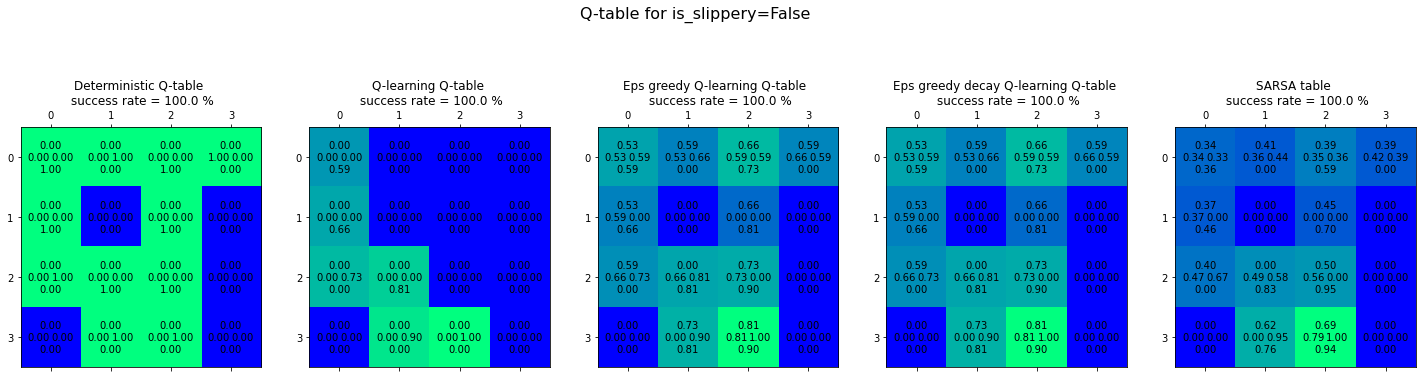

In [37]:
deterministic_q_table = np.load("data/deterministic_q_table.npy")

fig, ax = plt.subplots(1, 5)
fig.suptitle("Q-table for is_slippery=False", fontsize=16)

fig.set_size_inches(25, 7)
# im = Image.open('images/frozen_lake.jpg')
plt.title("Q-table of the game")

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)

map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)

map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)

map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

map_s = np.sum(sarsa_table, axis = 1)
map_s= map_s.reshape(4, 4)


# ax[0].imshow(im, alpha=1)
# ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')
ax[4].matshow(map_s, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
sarsa_reshaped =sarsa_table.reshape((4,4,4))


deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title(f"Deterministic Q-table \n success rate = {100*round(success_rate_d,2)} %")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title(f"Q-learning Q-table \n success rate = {100*round(success_rate_q,2)} %")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title(f"Eps greedy Q-learning Q-table  \n success rate = {100*round(success_rate_q_greedy,2)} %")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title(f"Eps greedy decay Q-learning Q-table \n success rate = {100*round(success_rate_q_greedy_decay,2)} %")

        ax[4].text(j-deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[4].text(j, i+deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[4].text(j+deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[4].text(j, i-deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[4].set_title(f"SARSA table \n success rate = {100*round(success_rate_sarsa,2)} %")
plt.show()

Then we'll define a play function for our game to test the performance

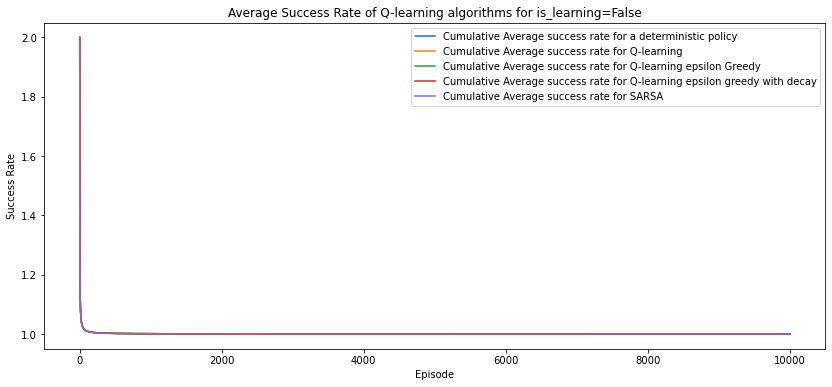

In [38]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")
plt.plot(np.arange(len(rewards_sarsa)), np.cumsum(rewards_sarsa)/np.arange(len(rewards_sarsa)), label="Cumulative Average success rate for SARSA")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms for is_learning=False')
plt.legend()
plt.show()

## 3. Results with the condition `is_slippery = True`

In [39]:
env_slip = gym.make("FrozenLake-v1", is_slippery=True, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)

### 3.1. Algorithms' results

In [40]:
q_table = q_train(env_slip)
q_table_greedy = q_train_greedy(env_slip)
q_table_greedy_decay=q_train_greedy_decay(env_slip, alpha = 0.1, gamma = 0.99, min_epsilon=0.5)
sarsa_table = sarsa_train(env_slip)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 789.30it/s]


Finished Q-learning algorithm.
Average reward is : 0.0432
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 630.53it/s]


Finished Q-learning algorithm.
Average reward is : 0.0304
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:19<00:00, 511.70it/s]


Finished Q-learning algorithm.
Average reward is : 0.0564


100%|██████████| 10000/10000 [00:17<00:00, 579.65it/s]


In [41]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env_slip, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env_slip, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env_slip, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env_slip, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env_slip, q_table=sarsa_table)

100%|██████████| 10000/10000 [00:02<00:00, 3487.49it/s]


Success rate is = 4.91 %
Average number of steps before end (success or fall) = 5.1212


100%|██████████| 10000/10000 [00:03<00:00, 3003.16it/s]


Success rate is = 4.1000000000000005 %
Average number of steps before end (success or fall) = 6.155


100%|██████████| 10000/10000 [00:03<00:00, 2725.33it/s]


Success rate is = 3.9 %
Average number of steps before end (success or fall) = 7.2516


100%|██████████| 10000/10000 [00:19<00:00, 525.04it/s]


Success rate is = 70.54 %
Average number of steps before end (success or fall) = 41.7833


100%|██████████| 10000/10000 [00:12<00:00, 826.50it/s]

Success rate is = 39.71 %
Average number of steps before end (success or fall) = 24.406


> Let's make some comments.

Keep in mind that we are in the situation where `is_slippery = True`, meaning that when the agent choose to go one way, the probability that he really goes this way is $\frac{1}{3}$, and he could go on a perpendicular direction with probability $\frac{1}{3}$, for each perpendicular direction. In this case, it is impossible to reach 100% success. 
The deterministic table, with only ones or zeros, has no flexibility : the agent always want to use the same path, but due to the randomness, he almost always fails.

With the basic Q-learning algorithm, we will always get a 0% success rate if we start with a initial q-table filled with 0. Indeed, since Python `np.argmax` function always give the first action maximizing, and since we start with everything at 0, this function will always return 0, meaning that the agent will always try to go left. Due to `is_slippery = True`, the agent may or may not move (going left, when starting, is not possible), but won't get any reward (no reward are granted until the goal is reached). Thus, at next step, the agent will again try to go left (the q-table updating stage won't modify any values). With such a policy, the agent is unlikely to ever reach the goal. Using the `action_max_function` we implemented earlier add some randomness and increase the probability to reach the goal, but as we can see, it is far from being sufficient.

The two other Q-learning algorithms also help avoid this problem, by allowing the agent taking random actions, and not always the same one "going left". This increases the probability to reach the goal. The SARSA algorithm also uses randomness to choose actions. The parameters, such as `gamma`, `epsilon` or `alpha` may have great influence on the results. Some parameters tuning may be useful in this case.

### 3.2. Hyperparameter tuning

Considering that the results may be highly influenced by the parameters, let's try some tuning, for the $\epsilon$-greedy decay Q-learning and SARSA algorithms.

In [ ]:
# Qlearning optimization
alpha = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.99]
gamma = [0.5, 0.8, 0.9, 0.95, 0.99, 1]
epsilon = [0.01, 0.05, 0.1, 0.5]

alphas=[]
success_rates = []
gammas=[]
epsilons=[]
rewards =[]
for al in alpha :
    for ga in gamma :
        for ep in epsilon :
            q_table = q_train_greedy_decay(env_slip, alpha=al, gamma=ga, min_epsilon=ep)
            reward, success_rate, avg_nb_steps = agent_play(env_slip, q_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)
            epsilons.append(ep)
            rewards.append(reward)

In [43]:
df = pd.DataFrame()
df["alpha"]=alphas
df["gamma"]=gammas
df["epsilon"]=epsilons
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

,alpha,gamma,epsilon,success_rate
42,0.05,0.99,0.10,0.7488
160,0.99,0.99,0.01,0.7455
108,0.80,0.95,0.01,0.7451
67,0.10,0.99,0.50,0.7449
91,0.50,0.99,0.50,0.7444
...,...,...,...,...
136,0.90,0.99,0.01,0.0000
118,0.80,1.00,0.10,0.0000
134,0.90,0.95,0.10,0.0000
119,0.80,1.00,0.50,0.0000


In [ ]:
fig, axes = plt.subplots(figsize=(14, 6))
title = f"Cummulative Average reward for Q-epsilon greedy decay for different parameters \n best success rate : {round(100*df.iloc[0]['success_rate'],2)} % \n best parameters : alpha = {df.iloc[0]['alpha']}, epsilon = {df.iloc[0]['epsilon']}, gamma = {df.iloc[0]['gamma']} "
plt.title(title)
for i in range(len(df)):
    plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
plt.legend()
plt.show();

![images/output0.png](images/output0.png)

In [46]:
q_table_greedy_decay = q_train_greedy_decay(env_slip, alpha = 0.1, gamma = 0.99, min_epsilon=0.5)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1327.37it/s]

Finished Q-learning algorithm.
Average reward is : 0.06


In [ ]:
# SARSA optimization
alpha = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.99]
gamma = [0.5, 0.8, 0.9, 0.95, 0.99, 1]
epsilon = [0.01, 0.05, 0.1, 0.5]
alphas=[]
success_rates = []
gammas=[]
epsilons=[]
rewards=[]
for al in alpha :
    for ga in gamma :
        for eps in epsilon :
            sarsa_table = sarsa_train(env_slip, al, ga, eps, episodes = 10000, steps = 100)
            reward, success_rate, avg_nb_steps = agent_play(env_slip, sarsa_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)
            epsilons.append(eps)
            rewards.append(reward)

In [48]:
df = pd.DataFrame()

df["epsilon"]=epsilons
df["alpha"]=alphas
df["gamma"]=gammas
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

,epsilon,alpha,gamma,success_rate
133,0.05,0.90,0.95,0.7488
132,0.01,0.90,0.95,0.7435
88,0.01,0.50,0.99,0.7415
140,0.01,0.90,1.00,0.7394
65,0.05,0.10,0.99,0.7388
...,...,...,...,...
119,0.50,0.80,1.00,0.0000
108,0.01,0.80,0.95,0.0000
134,0.10,0.90,0.95,0.0000
107,0.50,0.80,0.90,0.0000


In [ ]:
fig, axes = plt.subplots(figsize=(14, 6))
title = f"Cummulative Average reward for SARSA for different parameters \n best success rate : {round(100*df.iloc[0]['success_rate'],2)} % \n best parameters : alpha = {df.iloc[0]['alpha']}, epsilon = {df.iloc[0]['epsilon']}, gamma = {df.iloc[0]['gamma']} "
plt.title(title)
for i in range(len(df)):
    plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
plt.legend()
plt.show()

![images/output.png](images/output.png)

In [50]:
sarsa_table = sarsa_train(env_slip, alpha = 0.1, gamma = 0.99, epsilon = 0.1, episodes = 10000, steps = 100)

100%|██████████| 10000/10000 [00:19<00:00, 520.97it/s]


Recalculting the performances...

In [51]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env_slip, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env_slip, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env_slip, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env_slip, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env_slip, q_table=sarsa_table)

100%|██████████| 10000/10000 [00:01<00:00, 6786.09it/s]


Success rate is = 4.6 %
Average number of steps before end (success or fall) = 5.0582


100%|██████████| 10000/10000 [00:22<00:00, 451.58it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0


100%|██████████| 10000/10000 [00:01<00:00, 6515.66it/s]


Success rate is = 3.62 %
Average number of steps before end (success or fall) = 7.3836


100%|██████████| 10000/10000 [00:13<00:00, 725.58it/s]


Success rate is = 48.96 %
Average number of steps before end (success or fall) = 63.4323


100%|██████████| 10000/10000 [00:07<00:00, 1426.91it/s]

Success rate is = 60.029999999999994 %
Average number of steps before end (success or fall) = 36.2349


As we can, the performances of both the $\epsilon$-greedy decay Q-learning algorithm and the SARSA algorithm have been increased.

### 3.3. Comparison

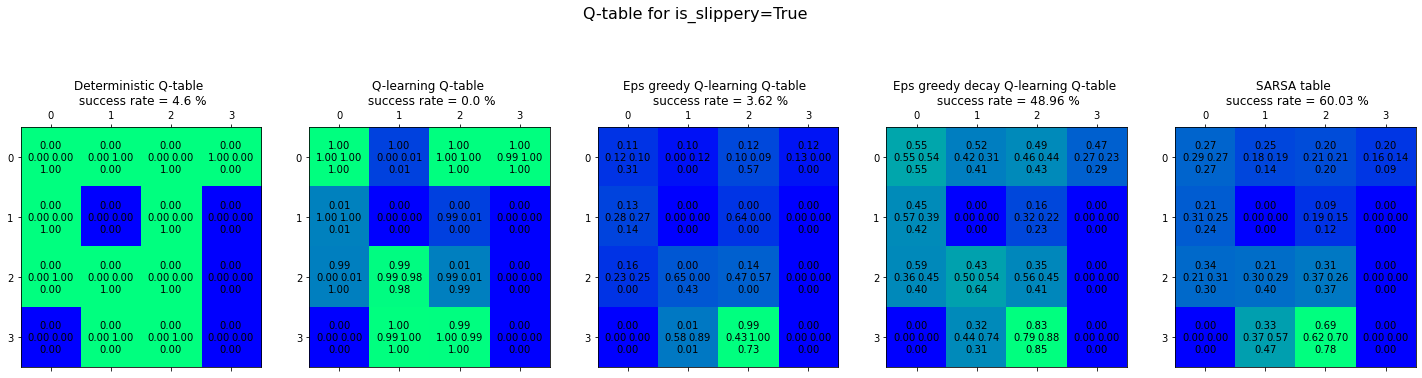

In [52]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(25, 7)
# im = Image.open('images/frozen_lake.jpg')
fig.suptitle("Q-table for is_slippery=True", fontsize=16)

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)

map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)

map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)

map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

map_s = np.sum(sarsa_table, axis = 1)
map_s= map_s.reshape(4, 4)


# ax[0].imshow(im, alpha=1)
# ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')
ax[4].matshow(map_s, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
sarsa_reshaped =sarsa_table.reshape((4,4,4))


deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title(f"Deterministic Q-table \n success rate = {round(100*success_rate_d,2)} %")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title(f"Q-learning Q-table \n success rate = {round(100*success_rate_q,2)} %")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title(f"Eps greedy Q-learning Q-table  \n success rate = {round(100*success_rate_q_greedy,2)} %")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title(f"Eps greedy decay Q-learning Q-table \n success rate = {round(100*success_rate_q_greedy_decay,2)} %")

        ax[4].text(j-deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[4].text(j, i+deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[4].text(j+deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[4].text(j, i-deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[4].set_title(f"SARSA table \n success rate = {round(100*success_rate_sarsa,2)} %")
plt.show()

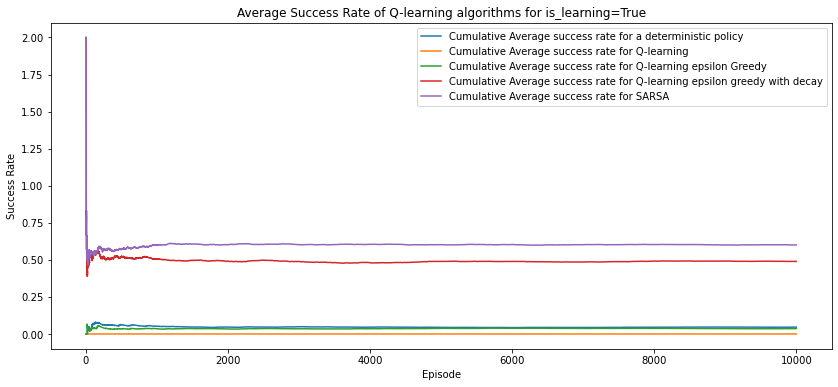

In [53]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")
plt.plot(np.arange(len(rewards_sarsa)), np.cumsum(rewards_sarsa)/np.arange(len(rewards_sarsa)), label="Cumulative Average success rate for SARSA")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms for is_learning=True')
plt.legend()
plt.show()

## 4. Conclusion :
We've established 3 variations of the Q-learning algorithm. As well as the SARSA algorithm, we've benchmarked their performance for both `slippery` and `non-slippery` environments. Furthermore, we've optimized their performance through a manual grid search of the hyperparameters.